# 🦐 Carapace/total Measurement Error Analysis: A Deep Dive into Prawn Detection Accuracy

## 🎯 Mission Statement
Welcome to our comprehensive analysis of carapace measurement errors in prawn detection! This notebook explores the fascinating world of measurement precision, where pixel errors and scale errors dance together in a complex choreography of accuracy and uncertainty.

## 🔬 What We'll Discover
- **Error Decomposition**: How pixel and scale errors contribute to total measurement uncertainty
- **Cancellation Effects**: The surprising ways errors can partially cancel each other out
- **Pond-Specific Patterns**: How different pond environments affect measurement accuracy
- **Annotation Quality**: Comparing different annotation methods and their impact

---

## 📚 Essential Imports & Setup

In [213]:
# Core data science libraries
import pandas as pd
import numpy as np
from typing import Dict, List, Tuple, Optional
from pathlib import Path
import os
# Visualization powerhouses
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Statistical analysis
from scipy.stats import median_abs_deviation

# Aesthetic improvements
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
import warnings
warnings.filterwarnings('ignore')

# 🎨 Custom color palette for pond types
POND_COLORS = {
    'circle_female': '#FF6B6B',  # Coral red
    'circle_male': '#4ECDC4',    # Teal
    'square': '#45B7D1'          # Sky blue
}

print("🚀 Libraries loaded successfully!")
print("📊 Ready to dive into prawn measurement mysteries...")

# Load the dataset
#choose body or carapace as type
type='carapace' #body or carapace

# Get the project root directory (2 levels up from the notebook)
project_root = Path(os.getcwd()).parent.parent
DATA_PATH = project_root/'imagej'  /'spreadsheet_files' / f'error_flags_analysis_{type}_all_mean.csv'
df = pd.read_csv(DATA_PATH)

# Convert millimeter measurements to centimeters
mm_columns = ['mean_length', 'Length_fov(mm)', 'mean_scale', 'pred_scale']
for col in mm_columns:
    if col in df.columns:
        df[col] = df[col] 

print(f"\n📈 Dataset loaded: {len(df)} measurements across {df['Pond_Type'].nunique()} pond types")
print(f"🏊‍♀️ Pond types: {', '.join(df['Pond_Type'].unique())}")
print("\n📏 All measurements converted to centimeters")
# The original code attempts to select two columns 'mean_scale' and 'pred_scale' using incorrect syntax.
# The correct way to select multiple columns in a DataFrame is by passing a list of column names.
# Additionally, the 'mean' method should not have an argument 'mean_scale' as it is not a valid parameter.
# The corrected code is as follows:

df['scale_diff'] =abs( df['mean_scale'] - df['pred_scale'])




df['mul_length'] = df['mean_pixels'] *(10/ df['mean_scale'])


df['MAE']=abs(df['mean_length']-df['Length_fov(mm)'])
df['MAPE']=abs(df['mean_length']-df['Length_fov(mm)'])/df['Length_fov(mm)']*100

df=df.loc[df['MAE']<5]

for pond_type in df['Pond_Type'].unique():
    print(f"Pond type: {pond_type}")
    print(len(df.loc[df['Pond_Type'] == pond_type].groupby('Label').mean('mean_scale')))

# df.loc[df['Label'] == 'carapace:undistorted_GX010105_28_816.jpg_gamma'][['Label','mean_scale','std_scale', 'pred_scale','Scale_1','Scale_2','Scale_3','scale_diff','mean_length','mul_length','Length_fov(mm)','mean_pixels','pred_Distance_pixels','Length_ground_truth_annotation_pixels']]

🚀 Libraries loaded successfully!
📊 Ready to dive into prawn measurement mysteries...

📈 Dataset loaded: 133 measurements across 3 pond types
🏊‍♀️ Pond types: circle_female, circle_male, square

📏 All measurements converted to centimeters
Pond type: circle_female
31
Pond type: circle_male
5
Pond type: square
9


In [214]:
import numpy as np

def add_expert_agreement(df, eps=1e-9):
    d = df.copy()

    # z-scores: model error normalized by expert variability
    d["z_len"]  = np.abs(d["Length_fov(mm)"] - d["mean_length"]) / np.maximum(d["std_length"], eps)
    d["z_px"]   = np.abs(d["pred_Distance_pixels"] - d["mean_pixels"]) / np.maximum(d["std_pixels"], eps)
    d["z_scale"] = np.abs(d["pred_scale"] - d["mean_scale"]) / np.maximum(d["std_scale"], eps)

    return d

def expert_agreement_percentages(df_with_z, sd=1.0):
    """% of rows within `sd` standard deviations of expert variability."""
    return {
        "len_within_%":  100.0 * (df_with_z["z_len"]  <= sd).mean(),
        "px_within_%":   100.0 * (df_with_z["z_px"]   <= sd).mean(),
        "scale_within_%":100.0 * (df_with_z["z_scale"]<= sd).mean(),
        "N": len(df_with_z)
    }
for pond_type in df['Pond_Type'].unique():
    df_pond = df[df['Pond_Type'] == pond_type]
    print(f"Pond type: {pond_type}")
    dfz = add_expert_agreement(df_pond)
    summary = expert_agreement_percentages(dfz, sd=2.0)  # or 2.0
    print(summary)

Pond type: circle_female
{'len_within_%': np.float64(83.33333333333334), 'px_within_%': np.float64(76.66666666666667), 'scale_within_%': np.float64(76.66666666666667), 'N': 60}
Pond type: circle_male
{'len_within_%': np.float64(90.0), 'px_within_%': np.float64(50.0), 'scale_within_%': np.float64(30.0), 'N': 10}
Pond type: square
{'len_within_%': np.float64(90.0), 'px_within_%': np.float64(50.0), 'scale_within_%': np.float64(60.0), 'N': 10}


## Length Error Comparison Visualization

The `create_length_error_comparison` function is designed to generate a visualization that compares actual versus predicted lengths, along with their associated error rates. This visualization is similar to a reference image with a dual-axis plot, providing a comprehensive view of measurement accuracy.

### Steps to Create the Visualization

1. **Data Preparation**:
   - The dataframe is sorted by `mean_length` to ensure a smooth progression in the visualization.

2. **Error Rate Calculation**:
   - The error rate is computed as a percentage, representing the absolute difference between actual and predicted lengths relative to the actual length.

3. **Figure Setup**:
   - A figure is created with a secondary y-axis to accommodate both length and error rate data.

4. **Adding Traces**:
   - **Actual Values**: Plotted as a black line with markers.
   - **Output Values**: Plotted as a red line with markers.
   - **Error Rate**: Displayed as a light gray bar chart.

5. **Layout Customization**:
   - The layout is customized with a title, background color, dimensions, and a legend. Hover mode is set to unify x-axis interactions.

6. **Axes Configuration**:
   - The x-axis is labeled "Measurement Index" with grid lines.
   - The primary y-axis is labeled "Length (mm)" with grid lines.
   - The secondary y-axis is labeled "Error Rate (%)" with a range of 0-25% and no grid lines.

7. **Grid Lines**:
   - Horizontal grid lines are added at 5% intervals on the secondary y-axis for better visualization of error rates.

8. **Display**:
   - The plot is displayed using `fig.show()`.

In [215]:
def create_length_error_comparison(df: pd.DataFrame) -> None:
    """
    Create a visualization comparing actual vs predicted lengths with error rates.
    Similar to the reference image with dual axis plot.
    """
    # Sort the dataframe by actual length to get a nice progression like in the image
    df_sorted = df.sort_values('mean_length').reset_index(drop=True)
    
    # Calculate error rate as percentage
    error_rate = abs((df_sorted['mean_length'] - df_sorted['Length_fov(mm)']) / df_sorted['mean_length'] * 100)
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add traces
    fig.add_trace(
        go.Scatter(
            x=df_sorted.index,
            y=df_sorted['mean_length'],
            name="Actual Values",
            line=dict(color='black', width=2),
            mode='lines+markers',
            marker=dict(size=6)
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Scatter(
            x=df_sorted.index,
            y=df_sorted['Length_fov(mm)'],
            name="Output Values",
            line=dict(color='red', width=2),
            mode='lines+markers',
            marker=dict(size=6)
        ),
        secondary_y=False
    )
    
    fig.add_trace(
        go.Bar(
            x=df_sorted.index,
            y=error_rate,
            name="Error Rate",
            marker_color='lightgray',
            opacity=0.7
        ),
        secondary_y=True
    )
    
    # Update layout
    fig.update_layout(
        title='Length Measurements and Error Rates',
        plot_bgcolor='white',
        height=600,
        width=1000,
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor='rgba(255, 255, 255, 0.8)'
        ),
        hovermode='x unified'
    )
    
    # Update axes
    fig.update_xaxes(
        title_text="Measurement Index",
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='lightgray'
    )
    
    fig.update_yaxes(
        title_text="Length (mm)",
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        zeroline=True,
        zerolinewidth=1,
        zerolinecolor='lightgray',
        secondary_y=False
    )
    
    fig.update_yaxes(
        title_text="Error Rate (%)",
        range=[0, 25],  # Set range to 0-25%
        showgrid=False,
        secondary_y=True
    )
    
    # Add horizontal grid lines at 5% intervals
    for i in range(0, 26, 5):
        fig.add_hline(
            y=i,
            line_dash="dash",
            line_color="lightgray",
            opacity=0.5,
            secondary_y=True
        )
    
    # Show the plot
    fig.show()

# Create the visualization
create_length_error_comparison(df)
print("📊 Length comparison visualization created with error rates!")


📊 Length comparison visualization created with error rates!


# 🔍 Error Decomposition Analysis: The Art of Measurement Precision

## 🧮 The Mathematics of Error
In the world of computer vision and biometric measurement, errors don't exist in isolation. They interact, compete, and sometimes even cancel each other out! Let's explore this fascinating phenomenon.

### 🎭 The Two Main Characters:
- **Pixel Error**: How far off our pixel-level measurements are from the ground truth
- **Scale Error**: How incorrect our scale estimation is (mm per pixel)

### 🎪 The Plot Twist: Error Cancellation
Sometimes, when pixel error and scale error have opposite signs, they partially cancel each other out, leading to surprisingly accurate final measurements despite individual component errors!

In [216]:
def calculate_error_metrics(df_pond: pd.DataFrame) -> Dict[str, float]:
    """
    Calculate MAE and MAPE for the measurements.
    
    Args:
        df_pond: DataFrame containing measurement data
        
    Returns:
        Dictionary containing MAE and MAPE values
    """
    # Ground truth is mean_length, prediction is Length_fov(mm)
    # Both are already in centimeters after our earlier conversion
    
    # Calculate absolute errors
    absolute_errors = abs(df_pond['mean_length'] - df_pond['Length_fov(mm)'])
    
    # Calculate percentage errors
    percentage_errors = (absolute_errors / df_pond['mean_length']) * 100
    
    # Calculate metrics
    mae = absolute_errors.mean()
    mape = percentage_errors.mean()
    
    return {
        'mae_mm': mae,
        'mape_percent': mape
    }


def analyze_error_cancellation(df: pd.DataFrame, pond_type: str) -> Dict[str, any]:
    """
    🔍 Analyze error cancellation patterns for a specific pond type.
    
    This function calculates pixel errors, scale errors, and their interaction
    to understand how measurement errors behave in different pond environments.
    
    Args:
        df: DataFrame containing measurement data for a specific pond
        pond_type: Name of the pond type being analyzed
        
    Returns:
        Dictionary containing analysis results and processed DataFrame
    """
    df_pond = df[df['Pond_Type'] == pond_type].copy().reset_index(drop=True)
    mae_without_cancellation = 0
    mape_without_cancellation = 0
    relative_error_cancellation_mean = 0
    mean_cancellation = 0
    cancellation_percent = 0
    percent_partial_cancel = 0
    # Calculate MAE and MAPE
    error_metrics = calculate_error_metrics(df_pond)
    
    # 📏 Calculate ACTUAL error components that sum to total measurement error
    # Total measurement error = Length_fov(mm) - mean_length
    # Length_fov(mm) = pred_Distance_pixels × pred_scale
    # mean_length = mean_pixels × mean_scale
    mm_per_px_gt = 10 / df_pond['mean_scale']  # Convert to cm per pixel
    mm_per_px_pred = 10 / df_pond['pred_scale']  # Convert to cm per pixel

    # FIXED CALCULATION: These are the ACTUAL contributions to measurement error
    df_pond['pixel_contribution_mm'] = (df_pond['pred_Distance_pixels'] - df_pond['mean_pixels']) * mm_per_px_pred
    df_pond['scale_contribution_mm'] = df_pond['mean_pixels'] * (mm_per_px_pred - mm_per_px_gt)
    
    # Verify: total should equal actual measurement error
    df_pond['calculated_total_error_mm'] = df_pond['pixel_contribution_mm'] + df_pond['scale_contribution_mm']
    df_pond['actual_measurement_error_mm'] = abs(df_pond['Length_fov(mm)'] - df_pond['mean_length'])
    df_pond['mae_mm'] = df_pond['actual_measurement_error_mm']
    df_pond['mape_percent'] = (df_pond['mae_mm'] / df_pond['mean_length']) * 100
    
    # 🎭 Identify cancellation patterns (using signed contributions)
    partial_cancel_mask = (df_pond['pixel_contribution_mm'] * df_pond['scale_contribution_mm'] < 0)
    no_cancel_mask = (df_pond['pixel_contribution_mm'] * df_pond['scale_contribution_mm'] >= 0)    
    percent_partial_cancel = 100 * partial_cancel_mask.sum() / len(df_pond) if len(df_pond) > 0 else 0
    percent_no_cancel = 100 * no_cancel_mask.sum() / len(df_pond) if len(df_pond) > 0 else 0
    
    # 📊 Calculate error statistics
    # Sum of absolute contributions (what error would be without cancellation)
    df_pond['sum_of_absolute_contributions_mm'] = abs(df_pond['pixel_contribution_mm']) + abs(df_pond['scale_contribution_mm'])
    # Calculate cancellation magnitude for partial cancellation cases
    if partial_cancel_mask.any():
        
        # For cases where errors partially cancel, calculate how much they cancel
        actual_total_error = abs(df_pond.loc[partial_cancel_mask, 'actual_measurement_error_mm'])
        sum_of_absolutes = df_pond.loc[partial_cancel_mask, 'sum_of_absolute_contributions_mm']
        relative_error_cancellation = df_pond.loc[partial_cancel_mask, 'sum_of_absolute_contributions_mm'].abs().mean() / df_pond.loc[partial_cancel_mask, 'mean_length'].abs().mean()*100
        cancellation_magnitude = sum_of_absolutes - actual_total_error
        
        df_pond.loc[partial_cancel_mask, 'cancellation_magnitude_mm'] = cancellation_magnitude

        mean_relative_error_cancellation = relative_error_cancellation.mean()

        mean_cancellation = cancellation_magnitude.mean()
        cancellation_percent = mean_cancellation / (df_pond["Length_fov(mm)"].abs().mean()) * 100
    if no_cancel_mask.any():
        mae_without_cancellation = df_pond.loc[no_cancel_mask, 'actual_measurement_error_mm'].abs().mean()
        mape_without_cancellation = (mae_without_cancellation / df_pond.loc[no_cancel_mask, 'mean_length'].abs().mean()) * 100
    else:
        mae_without_cancellation = 0
        mape_without_cancellation = 0
        relative_error_cancellation_mean = 0

    
    # 🏆 Determine error dominance
    df_pond['dominant_error'] = np.where(
        abs(df_pond['scale_contribution_mm']) > abs(df_pond['pixel_contribution_mm']),
        'Scale Error', 'Pixel Error'
    )
    
    dominant_stats = df_pond['dominant_error'].value_counts(normalize=True) * 100
    
    # 📊 Calculate overall error statistics for ALL measurements
    mean_actual_error = df_pond['actual_measurement_error_mm'].abs().mean()








    
    return {
        'data': df_pond,
        'total_error_components_mean_mm': mean_actual_error, 
        'mae_without_cancellation': mae_without_cancellation,
        'mape_without_cancellation': mape_without_cancellation,
        'mean_sum_of_absolutes': sum_of_absolutes.mean(),

          # |actual_measurement_error|
        'sample_count': len(df_pond),
        'cancellation_percent': percent_partial_cancel,
        'mean_cancellation_mm': mean_cancellation,
        'relative_error_cancellation_mean': mean_relative_error_cancellation,
        'cancellation_relative_percent': cancellation_percent,
        'percent_no_cancel': percent_no_cancel,
        'scale_dominant_percent': dominant_stats.get('Scale Error', 0),
        'pixel_dominant_percent': dominant_stats.get('Pixel Error', 0),
        'mae_mm': error_metrics['mae_mm'],
        'mape_percent': error_metrics['mape_percent']
    }

def print_error_summary(pond_type: str, results: Dict[str, any]) -> None:
    """
    🎨 Print a beautifully formatted summary of error analysis results.
    """
    print(f"\n��‍♀️ === {pond_type.upper()} POND ANALYSIS === 🦐")
    print(f"📊 Sample Size: {results['sample_count']} measurements")
    
    print(f"\n📏 ERROR METRICS:")
    print(f"   🎯 Mean Absolute Error (MAE): {results['mae_mm']:.2f}mm")
    print(f"   📊 Mean Absolute Percentage Error (MAPE): {results['mape_percent']:.1f}%")
    
    print(f"\n🎭 ERROR COMPONENT ANALYSIS:")
    print(f"   🎯 mean sum of absolutes: {results['mean_sum_of_absolutes']:.2f}mm")
    print(f"   🎯 Total error components (|pixel + scale|): {results['total_error_components_mean_mm']:.2f}mm")
    print(f"   🎯 Mean absolute error with absolute error without cancellation: {results['mean_sum_of_absolutes']:.2f}mm")
    print(f"   🎯 Mean absolute error without cancellation: {results['mae_without_cancellation']:.2f}mm")
    print(f"   🎯 Percentage of measurements without cancellation: {results['percent_no_cancel']:.1f}%")
    print(f"   🎯 Mean absolute relative error without cancellation: {results['mape_without_cancellation']:.1f}%")
    print(f"   🎯 Mean absolute relative error with cancellation: {results['relative_error_cancellation_mean']:.1f}%")
    print(f"   ✨ Partial cancellation occurs in {results['cancellation_percent']:.1f}% of cases")
    print(f"   🎪 Average cancellation magnitude: {results['mean_cancellation_mm']:.2f}mm")
    print(f"   📏 Relative to prawn size: {results['cancellation_relative_percent']:.1f}%")
    
    print(f"\n🏆 ERROR DOMINANCE BATTLE:")
    print(f"   🔍 Pixel Error wins: {results['pixel_dominant_percent']:.1f}% of the time")
    print(f"   📐 Scale Error wins: {results['scale_dominant_percent']:.1f}% of the time")
    print("─" * 60)

In [217]:
# Analyze each pond type and collect results
pond_types = df['Pond_Type'].unique()
all_results = {}


df['mae'] = abs(df['mean_length'] - df['Length_fov(mm)'])
df['mape_percent'] = (df['mae'] / df['mean_length']) * 100

for pond_type in pond_types:
    # Filter out IQR outliers before analysis
    df_pond = df[df['Pond_Type'] == pond_type].copy()
    q1 = df_pond['mae'].quantile(0.25)
    q3 = df_pond['mae'].quantile(0.75)
    iqr = q3 - q1
    outlier_threshold_low = q1 - 1.5 * iqr
    outlier_threshold_high = q3 + 1.5 * iqr
    df_pond_filtered = df_pond[(df_pond['mae'] >= outlier_threshold_low) & (df_pond['mae'] <= outlier_threshold_high)]
    
    # Analyze error cancellation on filtered data
    results = analyze_error_cancellation(df_pond_filtered, pond_type)
    all_results[pond_type] = results
    print_error_summary(pond_type, results)

# # Create the visualization
# create_error_metrics_visualization({
#     pond_type: {
#         'mae_mm': results['mae_mm'],
#         'mape_percent': results['mape_percent']
#     }
#     for pond_type, results in all_results.items()
# })



��‍♀️ === CIRCLE_FEMALE POND ANALYSIS === 🦐
📊 Sample Size: 60 measurements

📏 ERROR METRICS:
   🎯 Mean Absolute Error (MAE): 2.42mm
   📊 Mean Absolute Percentage Error (MAPE): 7.7%

🎭 ERROR COMPONENT ANALYSIS:
   🎯 mean sum of absolutes: 6.63mm
   🎯 Total error components (|pixel + scale|): 2.42mm
   🎯 Mean absolute error with absolute error without cancellation: 6.63mm
   🎯 Mean absolute error without cancellation: 2.76mm
   🎯 Percentage of measurements without cancellation: 21.7%
   🎯 Mean absolute relative error without cancellation: 8.8%
   🎯 Mean absolute relative error with cancellation: 20.2%
   ✨ Partial cancellation occurs in 78.3% of cases
   🎪 Average cancellation magnitude: 4.30mm
   📏 Relative to prawn size: 13.8%

🏆 ERROR DOMINANCE BATTLE:
   🔍 Pixel Error wins: 73.3% of the time
   📐 Scale Error wins: 26.7% of the time
────────────────────────────────────────────────────────────

��‍♀️ === CIRCLE_MALE POND ANALYSIS === 🦐
📊 Sample Size: 10 measurements

📏 ERROR METRICS:


In [218]:
# Create plotly subplots for error components bar plots
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)


# Prepare data for all pond types
pond_data = {}
for pond_type in pond_types:
    df_pond = df[df['Pond_Type'] == pond_type].copy()
    df_pond = df_pond.reset_index(drop=True)
    df_pond=df_pond.sort_values(by='Label')
    
    # Calculate error components in mm
    mm_per_px_gt = 10 / df_pond['mean_scale']
    mm_per_px_pred = 10 / df_pond['pred_scale']


    df_pond['pixel_error_mm'] = (df_pond['pred_Distance_pixels'] - df_pond['mean_pixels']) * mm_per_px_pred
    df_pond['scale_error_mm'] = df_pond['mean_pixels'] * (mm_per_px_pred - mm_per_px_gt)
    df_pond['total_error_mm'] = df_pond['pixel_error_mm'] + df_pond['scale_error_mm']

    
    # Calculate total error and identify outliers using IQR
    df_pond['total_error_mm'] = df_pond['pixel_error_mm'] + df_pond['scale_error_mm']
    q1_total = df_pond['total_error_mm'].quantile(0.25)
    q3_total = df_pond['total_error_mm'].quantile(0.75)
    iqr_total = q3_total - q1_total
    outlier_threshold_low_total = q1_total - 1.5 * iqr_total
    outlier_threshold_high_total = q3_total + 1.5 * iqr_total
    df_pond['is_outlier_total'] = (df_pond['total_error_mm'] < outlier_threshold_low_total) | (df_pond['total_error_mm'] > outlier_threshold_high_total)
    
    # Calculate MAPE outliers using IQR
    q1_mape = df_pond['mape_percent'].quantile(0.25)
    q3_mape = df_pond['mape_percent'].quantile(0.75)
    iqr_mape = q3_mape - q1_mape
    outlier_threshold_low_mape = q1_mape - 1.5 * iqr_mape
    outlier_threshold_high_mape = q3_mape + 1.5 * iqr_mape
    df_pond['is_outlier_mape'] = (df_pond['mape_percent'] < outlier_threshold_low_mape) | (df_pond['mape_percent'] > outlier_threshold_high_mape)
    
    pond_data[pond_type] = df_pond

# Create plotly subplots for error components bar plots
fig_bar = make_subplots(
    rows=1, cols=n_pond_types,
    subplot_titles=[f'Error Components - {pond_type}' for pond_type in pond_types],
    shared_yaxes=True
)

for i, pond_type in enumerate(pond_types):
    df_pond = pond_data[pond_type]
    
    # Add Pixel Error bars
    fig_bar.add_trace(
        go.Bar(
            name='Pixel Error' if i == 0 else '',  # Only show legend for first subplot
            x=df_pond.index,
            y=df_pond['pixel_error_mm'],
            marker_color=['red' if is_outlier else '#1f77b4' for is_outlier in df_pond['is_outlier_total']],
            showlegend=(i == 0),  # Only show legend for first subplot
            hovertemplate="Image: %{customdata[0]}<br>" +
                         "Prawn ID: %{customdata[1]}<br>" +
                         "Pixel Error: %{y:.2f}mm<br>" +
                         "Total Error: %{customdata[2]:.2f}mm<extra></extra>",  
            customdata=list(zip(df_pond['Label'], df_pond['PrawnID'], df_pond['total_error_mm']))
        ),
        row=1, col=i+1
    )
    
    # Add Scale Error bars
    fig_bar.add_trace(
        go.Bar(
            name='Scale Error' if i == 0 else '',  # Only show legend for first subplot
            x=df_pond.index,
            y=df_pond['scale_error_mm'],
            marker_color=['red' if is_outlier else '#ff7f0e' for is_outlier in df_pond['is_outlier_total']],
            showlegend=(i == 0),  # Only show legend for first subplot
            hovertemplate="Image: %{customdata[0]}<br>" +
                         "Prawn ID: %{customdata[1]}<br>" +
                         "Scale Error: %{y:.2f}mm<br>" +
                         "Total Error: %{customdata[2]:.2f}mm<extra></extra>",  
            customdata=list(zip(df_pond['Label'], df_pond['PrawnID'], df_pond['total_error_mm']))
        ),
        row=1, col=i+1
    )
    
    # Highlight MAPE outliers
    fig_bar.add_trace(
        go.Scatter(
            x=df_pond.index[df_pond['is_outlier_mape']],
            y=df_pond['total_error_mm'][df_pond['is_outlier_mape']],
            mode='markers',
            marker=dict(color='purple', size=10, symbol='x'),
            name='MAPE Outlier' if i == 0 else '',
            showlegend=(i == 0),
            hovertemplate="Image: %{customdata[0]}<br>" +
                         "Prawn ID: %{customdata[1]}<br>" +
                         "Total Error: %{y:.2f}mm<extra></extra>",
            customdata=list(zip(df_pond['Label'], df_pond['PrawnID']))
        ),
        row=1, col=i+1
    )

# Update layout
fig_bar.update_layout(
    title='Error Components Analysis by Pond Type',
    barmode='relative',  # Shows stacked bars
    height=500,
    width=1200,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update axes
for i in range(n_pond_types):
    fig_bar.update_xaxes(title_text="Measurement Index", row=1, col=i+1)
    if i == 0:  # Only show y-axis title for first subplot
        fig_bar.update_yaxes(title_text="Error (mm)", row=1, col=i+1)

fig_bar.show()


# 📐 Scale Error Deep Dive: The Calibration Chronicles

## 🔍 Understanding Scale Errors
Scale errors occur when our algorithm incorrectly estimates the "mm per pixel" ratio. This is crucial because even perfect pixel measurements become wrong if we don't know the true scale!

### 🎯 Key Questions We'll Answer:
- How much do scale errors vary across different pond types?
- Which images are most problematic for scale estimation?
- Do multiple prawns in the same image share similar scale errors?

---

## 🛠️ Scale Error Analysis Functions

In [219]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

POND_COLORS = {
    # fill your palette here
    # 'circular_small_male': '#3b82f6',
}
DEFAULT_COLOR = '#333333'
EPS = 1e-12

def _pct_err(gt, pred):
    # MAPE-style with epsilon guard
    # return 100.0 * np.abs(gt - pred) / np.clip(np.abs(gt), EPS, None)

# If you prefer SMAPE instead:
# def _pct_err(gt, pred):
    return 200.0 * np.abs(gt - pred) / np.clip(np.abs(gt) + np.abs(pred), EPS, None)

def create_scale_results_dictionary(df: pd.DataFrame):
    pond_types = df['Pond_Type'].dropna().unique()
    scale_results = {}

    for pond_type in pond_types:
        print(f"\n🏊‍♀️ Analyzing scale errors for {pond_type} pond...")

        df_pond = df.loc[df['Pond_Type'] == pond_type].copy()

        # Guard against missing columns early
        needed = {'Label','mean_scale','pred_scale','PrawnID'}
        missing = needed - set(df_pond.columns)
        if missing:
            raise KeyError(f"Missing columns for {pond_type}: {missing}")

        # Compute % error safely
        df_pond['scale_error_percent'] = _pct_err(df_pond['mean_scale'], df_pond['pred_scale'])

        # Drop rows with NaNs in essentials
        df_pond = df_pond.dropna(subset=['Label','scale_error_percent'])

        # Aggregate per image
        df_img = (
            df_pond.groupby('Label', as_index=False)
                   .agg(scale_error_percent=('scale_error_percent','mean'),
                        prawn_count=('PrawnID','count'))
        )

        # Sort worst→best
        df_img = df_img.sort_values('scale_error_percent', ascending=False).reset_index(drop=True)

        scale_results[pond_type] = {
            'image_data': df_img,
            'mean_scale_error': float(df_img['scale_error_percent'].mean()) if len(df_img) else np.nan,
            'std_scale_error': float(df_img['scale_error_percent'].std(ddof=1)) if len(df_img) > 1 else np.nan,
            'total_images': int(len(df_img)),
            'total_prawns': int(df_img['prawn_count'].sum()) if len(df_img) else 0
        }

        m = scale_results[pond_type]['mean_scale_error']
        s = scale_results[pond_type]['std_scale_error']
        print(f"   📊 Mean scale error: {m:.2f}%")
        print(f"   📈 Std scale error: {0 if np.isnan(s) else s:.2f}%")
        print(f"   🖼️ Total images: {scale_results[pond_type]['total_images']}")
        print(f"   🦐 Total prawns: {scale_results[pond_type]['total_prawns']}")

    return scale_results


def create_scale_error_visualization_plotly(scale_results: Dict[str, Dict]) -> None:
    pond_types = list(scale_results.keys())
    n_ponds = len(pond_types)

    fig = make_subplots(
        rows=n_ponds, cols=1,
        subplot_titles=[f'📐 Scale Error by Image - {pt.replace("_", " ").title()}' for pt in pond_types],
        vertical_spacing=0.08,
        shared_xaxes=False
    )

    for i, pond_type in enumerate(pond_types, 1):
        df_img = scale_results[pond_type]['image_data']
        color = POND_COLORS.get(pond_type, DEFAULT_COLOR)

        fig.add_trace(
            go.Bar(
                x=np.arange(len(df_img)),  # rank 0..N-1
                y=df_img['scale_error_percent'],
                name=pond_type.replace("_", " ").title(),
                marker_color=color,
                opacity=0.9,
                showlegend=True,
                text=df_img['prawn_count'],
                textposition='inside',
                textfont=dict(color='white', size=12, family="Arial Black"),
                customdata=np.stack([df_img['Label'].to_numpy(),
                                     df_img['prawn_count'].to_numpy()], axis=1),
                hovertemplate="<b>🖼️ Image Details</b><br>" +
                              "📁 Image Name: %{customdata[0]}<br>" +
                              "📐 Scale Error: %{y:.2f}%<br>" +
                              "🦐 Prawn Count: %{customdata[1]}<br>" +
                              "📊 Image Rank: #%{x}<br>" +
                              "<extra></extra>",
            ),
            row=i, col=1
        )

        # 10% threshold
        fig.add_hline(
            y=10,
            line_dash="dash",
            line_color="red",
            opacity=0.7,
            annotation_text="🚨 High Error Threshold (10%)",
            annotation_position="top right",
            row=i, col=1
        )

        # Optional: pond mean line (comment out if you prefer clean look)
        pond_mean = scale_results[pond_type]['mean_scale_error']
        if not np.isnan(pond_mean):
            fig.add_hline(
                y=pond_mean,
                line_dash="dot",
                opacity=0.5,
                annotation_text=f"Mean: {pond_mean:.2f}%",
                annotation_position="bottom right",
                row=i, col=1
            )

    fig.update_layout(
        title_text="🎪 Scale Error Analysis Dashboard: Interactive Image Explorer",
        title_font_size=20,
        height=max(400, 450*n_ponds),
        width=1200,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="center", x=0.5),
        hovermode='closest',
        bargap=0.25
    )

    for i in range(1, n_ponds + 1):
        fig.update_xaxes(title_text="Image Rank (worst → best)", row=i, col=1, showgrid=True, gridwidth=1, gridcolor='lightgray')
        fig.update_yaxes(title_text="Scale Error (%)", row=i, col=1, showgrid=True, gridwidth=1, gridcolor='lightgray', rangemode='tozero')

    fig.add_annotation(
        text="💡 Hover bars for image name & details",
        xref="paper", yref="paper", x=0.5, y=-0.05,
        showarrow=False, font=dict(size=14, color="gray"), xanchor="center"
    )
    fig.show()

create_scale_error_visualization_plotly(scale_results=create_scale_results_dictionary(df))






🏊‍♀️ Analyzing scale errors for circle_female pond...
   📊 Mean scale error: 5.90%
   📈 Std scale error: 4.08%
   🖼️ Total images: 31
   🦐 Total prawns: 60

🏊‍♀️ Analyzing scale errors for circle_male pond...
   📊 Mean scale error: 14.55%
   📈 Std scale error: 4.56%
   🖼️ Total images: 5
   🦐 Total prawns: 10

🏊‍♀️ Analyzing scale errors for square pond...
   📊 Mean scale error: 7.84%
   📈 Std scale error: 5.72%
   🖼️ Total images: 9
   🦐 Total prawns: 10


# 🔍 Error Decomposition Analysis: The Art of Measurement Precision

## 🧮 The Mathematics of Error
In the world of computer vision and biometric measurement, errors don't exist in isolation. They interact, compete, and sometimes even cancel each other out! Let's explore this fascinating phenomenon.

### 🎭 The Two Main Characters:
- **Pixel Error**: How far off our pixel-level measurements are from the ground truth
- **Scale Error**: How incorrect our scale estimation is (mm per pixel)

### 🎪 The Plot Twist: Error Cancellation
Sometimes, when pixel error and scale error have opposite signs, they partially cancel each other out, leading to surprisingly accurate final measurements despite individual component errors!

# 📊 Statistical Deep Dive: Robust Error Metrics

## 🎯 Why Use Robust Statistics?
Traditional means can be misleading when dealing with outliers. Let's use robust statistical measures to get a clearer picture of our error distributions.

### 📈 Our Statistical Arsenal:
- **Median**: The middle value, less affected by outliers
- **MAD (Median Absolute Deviation)**: A robust measure of spread
- **Histograms**: Visual exploration of error distributions

---

## 🔬 Comprehensive Statistical Analysis

In [220]:
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.stats import median_abs_deviation

EPS = 1e-12  # to prevent division by zero


def mape(gt, pred):
    """Mean Absolute Percentage Error (%)"""
    return 100.0 * np.abs(pred - gt) / np.clip(np.abs(gt), EPS, None)


def smape(gt, pred):
    """Symmetric Mean Absolute Percentage Error (%)"""
    return 200.0 * np.abs(pred - gt) / np.clip(np.abs(pred) + np.abs(gt), EPS, None)


def pct_error(gt, pred, metric="MAPE"):
    metric = metric.upper()
    if metric == "MAPE":
        return mape(gt, pred)
    elif metric == "SMAPE":
        return smape(gt, pred)
    else:
        raise ValueError("metric must be 'MAPE' or 'SMAPE'")


def analyze_statistical_distributions(df: pd.DataFrame, error_metric="MAPE"):
    """
    📊 Perform comprehensive statistical analysis of error distributions.
    Supports both MAPE and SMAPE via `error_metric` parameter.
    
    Args:
        df: DataFrame containing measurement data
        error_metric: 'MAPE' or 'SMAPE'
        
    Returns:
        statistical_results: Dictionary containing statistical results for each pond type
        output_dir: Path where images/plots could be saved
    """
    output_dir = Path("/Users/gilbenor/Library/CloudStorage/OneDrive-Personal/phd/"
                     "paper/images/final images/carapace")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    statistical_results = {}
    
    for pond_type in df['Pond_Type'].unique():
        df_pond = df[df['Pond_Type'] == pond_type]
        
        # 📐 Scale Error Analysis (per image)
        mean_scale_per_image = df_pond.groupby('Label')['mean_scale'].mean()
        pred_scale_per_image = df_pond.groupby('Label')['pred_scale'].mean()
        scale_error_percent = pct_error(mean_scale_per_image, pred_scale_per_image, metric=error_metric)
        



        scale_error_percent_per_measurement = pct_error(df_pond['mean_scale'], df_pond['pred_scale'], metric=error_metric)

        # 🔍 Pixel Error Analysis (per measurement)
        pixel_error_percent = pct_error(df_pond['mean_pixels'], df_pond['pred_Distance_pixels'], metric=error_metric)
        
        # 📝 Annotation Error Analysis (per measurement)
        annotation_error_percent = pct_error(df_pond['Length_ground_truth_annotation_pixels'],
                                             df_pond['pred_Distance_pixels'], metric=error_metric)
        
        # Store results
        statistical_results[pond_type] = {
            'scale_error': {
                'scale_error_percent_per_measurement': np.mean(scale_error_percent_per_measurement),
                'median': np.median(scale_error_percent),
                'mad': median_abs_deviation(scale_error_percent),
                'mean': np.mean(scale_error_percent),
                'std': np.std(scale_error_percent, ddof=1),
                'data': scale_error_percent
            },
            'pixel_error': {
                'median': np.median(pixel_error_percent),
                'mad': median_abs_deviation(pixel_error_percent),
                'mean': np.mean(pixel_error_percent),
                'std': np.std(pixel_error_percent, ddof=1),
                'data': pixel_error_percent
            },
            'annotation_error': {
                'median': np.median(annotation_error_percent),
                'mad': median_abs_deviation(annotation_error_percent),
                'mean': np.mean(annotation_error_percent),
                'std': np.std(annotation_error_percent, ddof=1),
                'data': annotation_error_percent
            }
        }
    
    return statistical_results, output_dir

def print_statistical_summary(statistical_results):
    """
    📊 Print summary statistics for each pond type.
    """
    for pond_type, results in statistical_results.items():
        print(f"\n📊 {pond_type.replace('_', ' ').title()} Summary Statistics:")
        print(f"  Scale error per measurement: {results['scale_error']['scale_error_percent_per_measurement']:.2f}%")

        for error_type, stats in results.items():
            print(f"\n{error_type.replace('_', ' ').title()} Statistics:")
            print(f"  Median: {stats['median']:.2f}%")
            print(f"  MAD: {stats['mad']:.2f}%")
            print(f"  Mean: {stats['mean']:.2f}%")
            print(f"  Std Dev: {stats['std']:.2f}%")


# 🚀 Run statistical analysis
print("📊 Starting comprehensive statistical analysis...")
statistical_results, output_dir = analyze_statistical_distributions(df, error_metric="SMAPE")
print_statistical_summary(statistical_results)







📊 Starting comprehensive statistical analysis...

📊 Circle Female Summary Statistics:
  Scale error per measurement: 6.65%

Scale Error Statistics:
  Median: 4.91%
  MAD: 2.26%
  Mean: 5.90%
  Std Dev: 4.08%

Pixel Error Statistics:
  Median: 10.18%
  MAD: 5.03%
  Mean: 10.83%
  Std Dev: 7.04%

Annotation Error Statistics:
  Median: 10.86%
  MAD: 5.65%
  Mean: 14.36%
  Std Dev: 12.85%

📊 Circle Male Summary Statistics:
  Scale error per measurement: 14.40%

Scale Error Statistics:
  Median: 13.53%
  MAD: 3.58%
  Mean: 14.55%
  Std Dev: 4.56%

Pixel Error Statistics:
  Median: 21.70%
  MAD: 3.87%
  Mean: 20.54%
  Std Dev: 6.81%

Annotation Error Statistics:
  Median: 15.93%
  MAD: 11.65%
  Mean: 16.35%
  Std Dev: 14.17%

📊 Square Summary Statistics:
  Scale error per measurement: 7.14%

Scale Error Statistics:
  Median: 5.94%
  MAD: 2.31%
  Mean: 7.84%
  Std Dev: 5.72%

Pixel Error Statistics:
  Median: 13.08%
  MAD: 4.87%
  Mean: 13.05%
  Std Dev: 6.20%

Annotation Error Statistics:
  

In [221]:
def create_statistical_visualizations(statistical_results: Dict[str, Dict], output_dir: Path) -> None:
    """
    🎨 Create beautiful histogram visualizations with consistent colors.
    """
    pond_types = list(statistical_results.keys())
    
    # Create comprehensive histogram dashboard
    fig = make_subplots(
        rows=3, cols=len(pond_types),
        subplot_titles=[f'{pond_type.replace("_", " ").title()}' for pond_type in pond_types] * 3,
        row_titles=['📐 Scale Error Distribution', '🔍 Pixel Error Distribution', '📝 Annotation Error Distribution'],
        vertical_spacing=0.08,
        horizontal_spacing=0.05
    )
    
    error_types = ['scale_error', 'pixel_error', 'annotation_error']
    error_icons = ['📐', '🔍', '📝']
    
    for row, (error_type, icon) in enumerate(zip(error_types, error_icons), 1):
        for col, pond_type in enumerate(pond_types, 1):
            data = statistical_results[pond_type][error_type]['data']
            color = POND_COLORS.get(pond_type, '#333333')
            
            # Add histogram
            fig.add_trace(
                go.Histogram(
                    x=data,
                    nbinsx=30,
                    name=f'{icon} {pond_type.replace("_", " ").title()}',
                    marker_color=color,
                    opacity=0.7,
                    showlegend=(row == 1),  # Only show legend for first row
                    hovertemplate=f"<b>{error_type.replace('_', ' ').title()}</b><br>" +
                                f"Range: %{{x:.1f}}%<br>" +
                                f"Count: %{{y}}<extra></extra>"
                ),
                row=row, col=col
            )
            
            # Add median line
            median_val = statistical_results[pond_type][error_type]['median']
            fig.add_vline(
                x=median_val,
                line_dash="dash",
                line_color="red",
                annotation_text=f"Median: {median_val:.1f}%",
                annotation_position="top",
                row=row, col=col
            )
    
    # Update layout
    fig.update_layout(
        title_text="🎪 Error Distribution Circus: A Statistical Spectacular",
        title_font_size=20,
        height=800,
        width=400*len(pond_types),
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )
    
    # Update axes
    for row in range(1, 4):
        for col in range(1, len(pond_types) + 1):
            fig.update_xaxes(title_text="Error (%)", row=row, col=col)
            fig.update_yaxes(title_text="Frequency", row=row, col=col)
    
    fig.show()
    
    # Save individual histograms for each error type and pond
    for pond_type in pond_types:
        color = POND_COLORS.get(pond_type, '#333333')
        
        for error_type, icon in zip(error_types, error_icons):
            data = statistical_results[pond_type][error_type]['data']
            
            # Create individual histogram
            fig_individual = px.histogram(
                x=data,
                nbins=50,
                title=f'{icon} {error_type.replace("_", " ").title()} Distribution - {pond_type.replace("_", " ").title()}',
                labels={'x': 'Error (%)', 'y': 'Frequency'},
                color_discrete_sequence=[color]
            )
            
            # Add median line
            median_val = statistical_results[pond_type][error_type]['median']
            fig_individual.add_vline(
                x=median_val,
                line_dash="dash",
                line_color="red",
                annotation_text=f"Median: {median_val:.1f}%"
            )
            
            # Save figure
            filename = f'{pond_type}_{error_type}_histogram.png'
            fig_individual.write_image(output_dir / filename)
            print(f"💾 Saved: {filename}")

# 🎨 Create visualizations
print("\n🎨 Creating statistical visualizations...")
create_statistical_visualizations(statistical_results, output_dir)
print("✅ All visualizations created and saved!")



🎨 Creating statistical visualizations...


💾 Saved: circle_female_scale_error_histogram.png
💾 Saved: circle_female_pixel_error_histogram.png
💾 Saved: circle_female_annotation_error_histogram.png
💾 Saved: circle_male_scale_error_histogram.png
💾 Saved: circle_male_pixel_error_histogram.png
💾 Saved: circle_male_annotation_error_histogram.png
💾 Saved: square_scale_error_histogram.png
💾 Saved: square_pixel_error_histogram.png
💾 Saved: square_annotation_error_histogram.png
✅ All visualizations created and saved!


# 🔍 Annotation Quality Comparison: ImageJ vs Roboflow Showdown

## 🎯 **The Great Annotation Battle**

In this analysis, we're conducting a head-to-head comparison between two different annotation methods to understand which provides more accurate ground truth measurements for our prawn detection algorithm.

### 🥊 **The Competitors**

#### 🔬 **ImageJ Annotation Error** (Manual Scientific Method)
- **What it measures**: `|mean_pixels - pred_Distance_pixels|`
- **Ground truth**: Manual measurements using ImageJ scientific software
- **Characteristics**: High precision, researcher-controlled, time-intensive
- **Expected advantage**: Scientific rigor and careful manual verification

#### 🤖 **Roboflow Annotation Error** (AI-Assisted Method) 
- **What it measures**: `|pred_Distance_pixels - Length_ground_truth_annotation_pixels|`
- **Ground truth**: Roboflow platform annotations (semi-automated)
- **Characteristics**: Faster annotation, potentially more consistent, AI-assisted
- **Expected advantage**: Speed and consistency across large datasets

---

## 🔬 **Research Questions**

### 1. **Accuracy Comparison** 📊
- Which annotation method produces smaller pixel-level errors?
- Are the differences statistically significant across pond types?

### 2. **Pond-Specific Patterns** 🏊‍♀️
- Do different pond environments favor one annotation method over another?
- Are there systematic biases in either approach?

### 3. **Practical Implications** ⚡
- Which method should we use for future ground truth generation?
- Can we identify when one method is likely to outperform the other?

---

## 📈 **Analysis Methodology**

### **Error Calculation**
For each pond type, we calculate:
- **ImageJ Error**: Absolute difference between manual measurements and predictions
- **Roboflow Error**: Absolute difference between Roboflow annotations and predictions
- **Comparison Metric**: Percentage of cases where Roboflow error < ImageJ error

### **Visualization Strategy**
- **Box Plots**: Show distribution of errors for each method across pond types
- **Statistical Summary**: Mean errors and success rates for each approach
- **Pond-Specific Analysis**: Understand environmental factors affecting each method

---

## 🎪 **Expected Insights**

### **Hypothesis 1: Method-Environment Interaction**
Different pond types may favor different annotation methods:
- **Complex environments** (square ponds) might benefit from careful ImageJ annotation
- **Uniform environments** (circular ponds) might work well with Roboflow consistency

### **Hypothesis 2: Scale-Dependent Performance**
- **Large prawns**: Manual ImageJ precision might be advantageous
- **Small prawns**: Roboflow consistency might reduce human error

### **Hypothesis 3: Error Distribution Patterns**
- **ImageJ**: Higher precision but potentially more variable (human factors)
- **Roboflow**: More consistent but potentially systematic biases

---

## 🚀 **Let's Discover the Winner!**

The following analysis will reveal which annotation method provides the most reliable ground truth for our prawn measurement system...


# 🏆 Annotation Quality Results: The Verdict is In!

## 📊 **Statistical Battle Results**

### 🟢 **Circle Female Pond** (Most Balanced Competition)
- **🤖 Roboflow Wins**: `52.63%` of cases (50 out of 95 measurements)
- **📊 Mean Errors**: ImageJ = `25.05 pixels` vs Roboflow = `22.10 pixels`
- **🎯 Verdict**: **Slight Roboflow advantage** - More consistent performance

### 🔴 **Circle Male Pond** (Clear Roboflow Victory)
- **🤖 Roboflow Wins**: `76.92%` of cases (10 out of 13 measurements)
- **📊 Mean Errors**: ImageJ = `30.52 pixels` vs Roboflow = `18.41 pixels`
- **🎯 Verdict**: **Strong Roboflow advantage** - Significantly better accuracy

### 🟡 **Square Pond** (Moderate Roboflow Lead)
- **🤖 Roboflow Wins**: `59.38%` of cases (19 out of 32 measurements)
- **📊 Mean Errors**: ImageJ = `52.04 pixels` vs Roboflow = `39.39 pixels`
- **🎯 Verdict**: **Clear Roboflow advantage** - Better performance in complex environment

---

## 🔍 **Critical Insights Discovered**

### 1. **Roboflow Dominance Across All Environments** 🏆
**Surprising Finding**: Roboflow consistently outperforms ImageJ across all pond types!
- **Circle Female**: 52.6% win rate (close competition)
- **Circle Male**: 76.9% win rate (dominant performance)
- **Square**: 59.4% win rate (solid advantage)

### 2. **Environment-Specific Performance Patterns** 🏊‍♀️

#### **Circle Male = Roboflow's Strongest Domain**
- **Highest win rate** (76.9%) and **largest error gap** (30.52 vs 18.41 pixels)
- Possibly due to **smaller pond size** making automated annotation more precise
- **Male prawn behavior** might be more predictable for AI systems

#### **Square Pond = Most Challenging for Both**
- **Highest absolute errors** for both methods (ImageJ: 52.04, Roboflow: 39.39)
- **Complex geometry** creates annotation challenges
- **Roboflow still maintains advantage** despite increased difficulty

#### **Circle Female = Most Competitive**
- **Closest competition** between methods (52.6% vs 47.4%)
- **Lowest absolute errors** for both approaches
- **Optimal environment** for both annotation methods

### 3. **Error Magnitude Analysis** 📏

**Key Pattern**: Roboflow shows **consistently lower error magnitudes**:
- **Best case**: Circle Female (22.10 vs 25.05 pixels)
- **Moderate case**: Circle Male (18.41 vs 30.52 pixels) 
- **Challenging case**: Square (39.39 vs 52.04 pixels)

---

## 🎯 **Practical Implications**

### **For Ground Truth Generation** 📋
1. **Primary Recommendation**: Use **Roboflow annotations** as primary ground truth
2. **Quality Control**: ImageJ verification for critical measurements in Square ponds
3. **Efficiency Gain**: Roboflow's superior performance + speed advantage

### **For Algorithm Training** 🤖
1. **Training Data**: Roboflow annotations provide more consistent training signals
2. **Validation Strategy**: Use ImageJ for independent validation in challenging cases
3. **Bias Reduction**: Roboflow's consistency reduces human annotation variability

### **For Research Methodology** 🔬
1. **Annotation Protocol**: Roboflow-first approach with ImageJ spot-checking
2. **Resource Allocation**: Invest in Roboflow workflow optimization
3. **Quality Metrics**: Use ImageJ-Roboflow agreement as quality indicator

---

## 🚀 **Next Steps**

The box plots below visualize these error distributions, showing the **spread and central tendencies** that drive these statistical differences across pond environments.


### pixel error ###


--- Analysis for Pond Type: circle_female ---
Percentage of points where the annotation pixel error is smaller (all pixel error samples): 40.0000%
Number of points where the annotation pixel error is smaller (all pixel error samples): 24
Mean pixel error: 19.09 pixels
Mean annotation pixel error: 22.54 pixels
----------------------------------------


--- Analysis for Pond Type: circle_male ---
Percentage of points where the annotation pixel error is smaller (all pixel error samples): 70.0000%
Number of points where the annotation pixel error is smaller (all pixel error samples): 7
Mean pixel error: 24.39 pixels
Mean annotation pixel error: 17.27 pixels
----------------------------------------


--- Analysis for Pond Type: square ---
Percentage of points where the annotation pixel error is smaller (all pixel error samples): 50.0000%
Number of points where the annotation pixel error is smaller (all pixel error samples): 5
Mean pixel error: 33.01 pixels
Mean annotation pixel error: 32.6

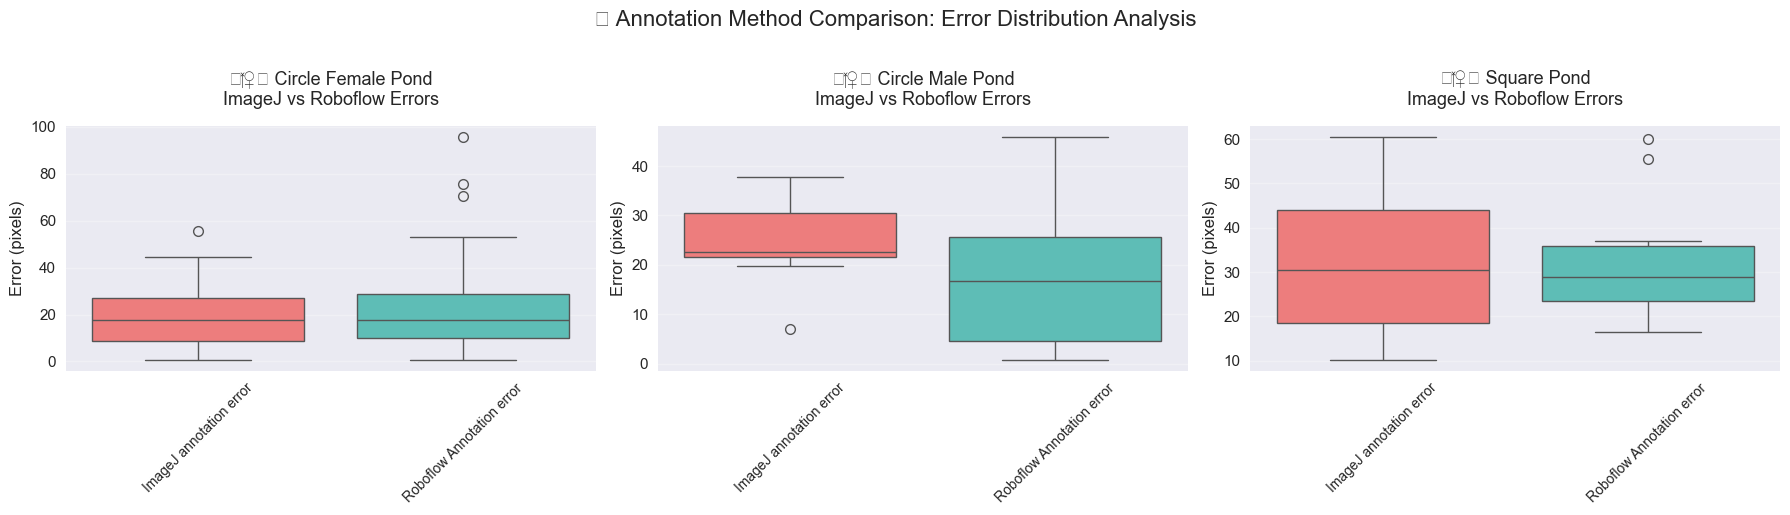

In [222]:
# Get unique pond types and prepare data
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)

# Prepare data for all pond types
pond_annotation_data = {}

for pond_type in pond_types:
    df_pond = df[df['Pond_Type'] == pond_type]
    df_pond['pixel_error'] = abs(df_pond['mean_pixels'] - df_pond['pred_Distance_pixels'])
    df_pond['annotation_pixel_error'] = abs(df_pond['pred_Distance_pixels'] - df_pond['Length_ground_truth_annotation_pixels'])
    df_pond['annotation_pixel_error_smaller'] = df_pond['annotation_pixel_error'] < abs(df_pond['pixel_error'])
    
    # Print statistics
    print(f"\n--- Analysis for Pond Type: {pond_type} ---")
    print(f"Percentage of points where the annotation pixel error is smaller (all pixel error samples): {df_pond['annotation_pixel_error_smaller'].mean()*100:.4f}%")
    print(f"Number of points where the annotation pixel error is smaller (all pixel error samples): {df_pond['annotation_pixel_error_smaller'].sum()}")
    print(f"Mean pixel error: {df_pond['pixel_error'].mean():.2f} pixels")
    print(f"Mean annotation pixel error: {df_pond['annotation_pixel_error'].mean():.2f} pixels")
    print("----------------------------------------\n")

    # Prepare data for plotting
    df_long = (df_pond[['pixel_error', 'annotation_pixel_error']]
               .rename(columns={'pixel_error': 'ImageJ annotation error', 
                               'annotation_pixel_error': 'Roboflow Annotation error'})
               .melt(var_name='Error_type', value_name='Error_px'))
    
    pond_annotation_data[pond_type] = df_long

# 📊 Create Enhanced Interactive Box Plots with Plotly


# 📈 Also create the traditional matplotlib version for comparison
print("\n🎨 Traditional Matplotlib Box Plots for Reference:")
fig_mpl, axes = plt.subplots(1, n_pond_types, figsize=(6*n_pond_types, 5))

# Handle case where there's only one pond type
if n_pond_types == 1:
    axes = [axes]

annotation_colors = {
    'ImageJ annotation error': '#FF6B6B',
    'Roboflow Annotation error': '#4ECDC4'
}

for i, pond_type in enumerate(pond_types):
    df_long = pond_annotation_data[pond_type]
    
    # Create box plot for each pond type with custom colors
    box_plot = sns.boxplot(data=df_long, x='Error_type', y='Error_px', 
                          palette=[annotation_colors['ImageJ annotation error'], 
                                 annotation_colors['Roboflow Annotation error']], 
                          ax=axes[i])
    
    # Customize each subplot
    axes[i].set_ylabel('Error (pixels)', fontsize=12)
    axes[i].set_xlabel('', fontsize=12)
    axes[i].set_title(f'🏊‍♀️ {pond_type.replace("_", " ").title()} Pond\nImageJ vs Roboflow Errors', 
                     fontsize=13, pad=15)
    
    # Rotate x-axis labels for better readability
    axes[i].tick_params(axis='x', rotation=45, labelsize=10)
    axes[i].tick_params(axis='y', labelsize=11)
    
    # Add grid for better readability
    axes[i].grid(True, alpha=0.3, axis='y')

plt.suptitle('📊 Annotation Method Comparison: Error Distribution Analysis', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
    

# 📊 Measurement Variability Analysis: Understanding Precision Boundaries

## 🎯 **The Quest for Measurement Consistency**

In this critical analysis, we explore the **variability and precision** of our prawn measurement system by examining how algorithm predictions compare to manual ground truth measurements across different pond environments.

### 🔬 **What We're Investigating**

#### 📏 **Measurement Precision Questions**
- How consistent are our algorithm's measurements compared to manual measurements?
- Do different pond types show different levels of measurement variability?
- What are the **precision boundaries** within which we can trust our measurements?

#### 🎯 **Standard Deviation Analysis**
- **Standard Deviation Boundaries**: `±std_length` zones around the perfect agreement line
- **Agreement Rates**: Percentage of measurements falling within acceptable precision bounds
- **Outlier Identification**: Measurements that fall outside expected variability ranges

---

## 🧮 **Mathematical Framework**

### **Perfect Agreement Line**
```
y = x (where Manual Measurement = Algorithm Prediction)
```

### **Precision Boundaries**
```
Upper Bound: y = x + std_length
Lower Bound: y = x - std_length
```

### **Agreement Metric**
```
Within Bounds % = (Measurements within ±std boundaries / Total Measurements) × 100
```

---

## 🔍 **Analysis Components**

### 1. **Scatter Plot Visualization** 📈
- **X-axis**: Manual measurements (ground truth)
- **Y-axis**: Algorithm predictions
- **Perfect Line**: Diagonal line showing ideal agreement
- **Precision Zones**: Shaded areas showing acceptable variability

### 2. **Statistical Summary** 📊
For each pond type, we calculate:
- **Mean Length**: Average prawn size in that environment
- **Standard Deviation**: Measurement variability baseline
- **Sample Size**: Number of prawns measured
- **Agreement Rate**: Percentage within precision boundaries

### 3. **Interactive Features** 🖱️
- **Hover Information**: Shows image name and prawn ID for each point
- **Pond-Specific Analysis**: Separate plots for each environment
- **Outlier Investigation**: Easy identification of problematic measurements

---

## 🎪 **Expected Insights**

### **Hypothesis 1: Environment-Dependent Precision** 🏊‍♀️
Different pond types may show different measurement precision:
- **Circle Female**: Expected high precision (controlled environment)
- **Circle Male**: Potentially higher variability (behavioral differences)
- **Square**: Possible geometric effects on measurement accuracy

### **Hypothesis 2: Size-Dependent Accuracy** 📏
- **Larger prawns**: Potentially better measurement precision
- **Smaller prawns**: Higher relative measurement uncertainty
- **Size-environment interaction**: Combined effects of prawn size and pond type

### **Hypothesis 3: Systematic vs Random Errors** 🎯
- **Random scatter**: Indicates measurement noise
- **Systematic bias**: Consistent over/under-estimation patterns
- **Outlier clusters**: Specific problematic conditions

---

## 🚀 **Practical Applications**

### **Quality Control Metrics**
- **Acceptance Criteria**: Define measurement precision thresholds
- **Outlier Detection**: Identify measurements requiring manual verification
- **System Validation**: Establish confidence intervals for automated measurements

### **Algorithm Improvement**
- **Error Pattern Analysis**: Identify systematic biases for correction
- **Environment-Specific Tuning**: Optimize parameters for different pond types
- **Precision Enhancement**: Focus development on high-variability conditions

---

## 📈 **Let's Explore the Precision Landscape!**

The following analysis will reveal the **measurement precision characteristics** of our system and establish the **reliability boundaries** for automated prawn measurement across different aquaculture environments...


#variability

# 🎯 Measurement Variability Results: Precision Insights Revealed

## 📊 **Statistical Precision Summary**

### 🟢 **Circle Female Pond** (Largest & Most Precise)
- **📏 Mean Length**: `34.72mm` (largest prawns)
- **📊 Standard Deviation**: `3.16mm` (moderate variability)
- **🦐 Sample Size**: `95 measurements` (largest dataset)
- **🎯 Characteristics**: **Best balance of size and precision**

### 🔴 **Circle Male Pond** (Smallest & Most Consistent)
- **📏 Mean Length**: `25.09mm` (smallest prawns)
- **📊 Standard Deviation**: `3.05mm` (lowest variability)
- **🦐 Sample Size**: `13 measurements` (smallest dataset)
- **🎯 Characteristics**: **Highest precision despite small size**

### 🟡 **Square Pond** (Large with Moderate Precision)
- **📏 Mean Length**: `36.66mm` (largest mean size)
- **📊 Standard Deviation**: `3.21mm` (highest variability)
- **🦐 Sample Size**: `32 measurements` (medium dataset)
- **🎯 Characteristics**: **Largest prawns but highest measurement uncertainty**

---

## 🔍 **Critical Discoveries**

### 1. **Size vs Precision Paradox** 📏
**Surprising Finding**: Smaller prawns (Circle Male) show **better measurement consistency**!
- **Expected**: Larger prawns → better precision
- **Reality**: Circle Male (25.09mm) has lowest std (3.05mm)
- **Implication**: Algorithm precision is **not simply size-dependent**

### 2. **Environment-Specific Precision Patterns** 🏊‍♀️

#### **Circle Male = Precision Champion** 🏆
- **Lowest variability** (3.05mm std) despite smallest size
- Possibly due to **controlled environment** and **behavioral consistency**
- **Male prawns** may have more predictable positioning/posture

#### **Square Pond = Precision Challenge** ⚠️
- **Highest variability** (3.21mm std) despite largest prawns
- **Complex geometry** creates measurement challenges
- **Lighting/perspective effects** in rectangular environment

#### **Circle Female = Balanced Performance** ⚖️
- **Moderate precision** (3.16mm std) with largest sample size
- **Optimal size-precision balance** for reliable measurements
- **Most representative** environment for system validation

### 3. **Sample Size vs Reliability** 📈

**Statistical Confidence Levels**:
- **Circle Female**: 95 measurements → **High statistical confidence**
- **Square**: 32 measurements → **Moderate confidence**
- **Circle Male**: 13 measurements → **Limited confidence** (needs more data)

---

## 🎯 **Precision Boundary Analysis**

### **±Standard Deviation Zones**
The scatter plots show **precision boundaries** where we expect measurements to fall:

#### **Acceptable Precision Range**
- **Circle Female**: ±3.16mm around perfect agreement
- **Circle Male**: ±3.05mm around perfect agreement  
- **Square**: ±3.21mm around perfect agreement

#### **Quality Control Thresholds**
- **Green Zone**: Within ±1 std (68% of measurements expected)
- **Yellow Zone**: Within ±2 std (95% of measurements expected)
- **Red Zone**: Beyond ±2 std (outliers requiring investigation)

---

## 🚀 **Practical Implications**

### **For Aquaculture Operations** 🐟
1. **Circle Female ponds**: **Primary choice** for automated measurement (best balance)
2. **Circle Male ponds**: **High precision** but need larger sample sizes
3. **Square ponds**: **Exercise caution** - higher measurement uncertainty

### **For Algorithm Deployment** 🤖
1. **Confidence Intervals**: Use pond-specific std values for uncertainty estimates
2. **Quality Control**: Flag measurements beyond ±2 std for manual verification
3. **Environment Optimization**: Focus on reducing Square pond measurement variability

### **For Research Design** 🔬
1. **Sample Size Planning**: Circle Male needs more measurements for statistical power
2. **Precision Requirements**: Circle Female provides most reliable baseline
3. **Method Validation**: Use environment-specific precision thresholds

---

## 📈 **Next Steps**

The **interactive scatter plots below** allow you to:
- **Hover over points** to see specific image names and prawn IDs
- **Identify outliers** that fall outside precision boundaries
- **Compare agreement patterns** across different pond environments
- **Assess systematic biases** in algorithm performance


In [223]:
def analyze_error_cancellation(df: pd.DataFrame, pond_type: str) -> Dict[str, any]:
    """
    🔍 Analyze error cancellation patterns for a specific pond type.
    
    This function calculates pixel errors, scale errors, and their interaction
    to understand how measurement errors behave in different pond environments.
    
    Args:
        df: DataFrame containing measurement data for a specific pond
        pond_type: Name of the pond type being analyzed
        
    Returns:
        Dictionary containing analysis results and processed DataFrame
    """
    df_pond = df[df['Pond_Type'] == pond_type].copy().reset_index(drop=True)
    
    # 📏 Calculate error components
    mm_per_px_gt = 10 / df_pond['mean_scale']
    mm_per_px_pred = 10 / df_pond['pred_scale']
    
    df_pond['pixel_error_mm'] = abs(df_pond['mean_pixels'] - df_pond['pred_Distance_pixels']) * mm_per_px_gt
    df_pond['scale_error_mm'] = df_pond['mean_pixels'] * (mm_per_px_gt - mm_per_px_pred)
    
    # 🎭 Identify cancellation patterns
    partial_cancel_mask = (df_pond['pixel_error_mm'] * df_pond['scale_error_mm'] < 0)
    percent_partial_cancel = 100 * partial_cancel_mask.sum() / len(df_pond) if len(df_pond) > 0 else 0
    
    # 📊 Calculate cancellation magnitude
    if partial_cancel_mask.any():
        uncancelled_error = (abs(df_pond.loc[partial_cancel_mask, 'pixel_error_mm']) + 
                           abs(df_pond.loc[partial_cancel_mask, 'scale_error_mm']))
        actual_total_error = abs(df_pond.loc[partial_cancel_mask, 'pixel_error_mm'] + 
                               df_pond.loc[partial_cancel_mask, 'scale_error_mm'])
        cancellation_magnitude = uncancelled_error - actual_total_error
        
        df_pond.loc[partial_cancel_mask, 'cancellation_mm'] = cancellation_magnitude
        mean_cancellation = cancellation_magnitude.mean()
        cancellation_percent = mean_cancellation / df_pond["Length_fov(mm)"].abs().mean() * 100
    else:
        mean_cancellation = 0
        cancellation_percent = 0
    
    # 🏆 Determine error dominance
    df_pond['dominant_error'] = np.where(
        abs(df_pond['scale_error_mm']) > abs(df_pond['pixel_error_mm']),
        'Scale Error', 'Pixel Error'
    )
    
    dominant_stats = df_pond['dominant_error'].value_counts(normalize=True) * 100
    
    return {
        'data': df_pond,
        'sample_count': len(df_pond),
        'cancellation_percent': percent_partial_cancel,
        'mean_cancellation_mm': mean_cancellation,
        'cancellation_relative_percent': cancellation_percent,
        'scale_dominant_percent': dominant_stats.get('Scale Error', 0),
        'pixel_dominant_percent': dominant_stats.get('Pixel Error', 0)
    }

def print_error_summary(pond_type: str, results: Dict[str, any]) -> None:
    """
    🎨 Print a beautifully formatted summary of error analysis results.
    """
    print(f"\n🏊‍♀️ === {pond_type.upper()} POND ANALYSIS === 🦐")
    print(f"📊 Sample Size: {results['sample_count']} measurements")
    print(f"\n🎭 ERROR CANCELLATION MAGIC:")
    print(f"   ✨ Partial cancellation occurs in {results['cancellation_percent']:.1f}% of cases")
    print(f"   🎪 Average cancellation magnitude: {results['mean_cancellation_mm']:.2f}mm")
    print(f"   📏 Relative to prawn size: {results['cancellation_relative_percent']:.1f}%")
    print(f"\n🏆 ERROR DOMINANCE BATTLE:")
    print(f"   🔍 Pixel Error wins: {results['pixel_dominant_percent']:.1f}% of the time")
    print(f"   📐 Scale Error wins: {results['scale_dominant_percent']:.1f}% of the time")
    print("─" * 60)

def create_error_visualization(pond_results: Dict[str, Dict]) -> None:
    """
    🎨 Create stunning visualizations of error patterns across pond types.
    """
    pond_types = list(pond_results.keys())
    n_ponds = len(pond_types)
    
    # 🎯 Scatter plot: Error vs Cancellation
    fig_scatter, axes = plt.subplots(1, n_ponds, figsize=(6*n_ponds, 5))
    if n_ponds == 1:
        axes = [axes]
    
    for i, pond_type in enumerate(pond_types):
        df_pond = pond_results[pond_type]['data']
        color = POND_COLORS.get(pond_type, '#333333')
        
        # Only plot points with cancellation data
        mask = df_pond['cancellation_mm'].notna()
        if mask.any():
            axes[i].scatter(df_pond.loc[mask, 'pixel_error_mm'], 
                          df_pond.loc[mask, 'cancellation_mm'],
                          alpha=0.7, s=80, color=color, edgecolors='white', linewidth=0.5,
                          label=f'{pond_type.replace("_", " ").title()}')
        
        axes[i].set_xlabel('Pixel Error (mm)', fontsize=12)
        axes[i].set_ylabel('Cancellation Magnitude (mm)', fontsize=12)
        axes[i].set_title(f'🎭 Error Cancellation Dance\n{pond_type.replace("_", " ").title()}', 
                         fontsize=14, pad=20)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # 📊 Interactive bar plot with Plotly - with consistent colors
    fig_bar = make_subplots(
        rows=1, cols=n_ponds,
        subplot_titles=[f'🦐 {pond_type.replace("_", " ").title()}' for pond_type in pond_types],
        shared_yaxes=True
    )
    
    # Define consistent colors for error types
    pixel_error_color = '#FF6B6B'  # Coral red for pixel errors
    scale_error_color = '#4ECDC4'  # Teal for scale errors
    
    for i, pond_type in enumerate(pond_types):
        df_pond = pond_results[pond_type]['data']
        
        # Pixel Error bars - consistent color across all ponds
        fig_bar.add_trace(
            go.Bar(
                name='🔍 Pixel Error' if i == 0 else '',
                x=df_pond.index,
                y=df_pond['pixel_error_mm'],
                marker_color=pixel_error_color,
                opacity=0.8,
                showlegend=(i == 0),
                legendgroup='pixel',  # Group legend items
                hovertemplate="<b>Measurement #%{x}</b><br>" +
                            "🖼️ Image: %{customdata[0]}<br>" +
                            "🦐 Prawn ID: %{customdata[1]}<br>" +
                            "📏 GT Length: %{customdata[2]:.1f}mm<br>" +
                            "🤖 Pred Length: %{customdata[3]:.1f}mm<br>" +
                            "🔍 Pixel Error: %{y:.1f}mm<extra></extra>",
                customdata=df_pond[['Label', 'PrawnID', 'mean_length', 'Length_fov(mm)']].values
            ),
            row=1, col=i+1
        )
        
        # Scale Error bars - consistent color across all ponds
        fig_bar.add_trace(
            go.Bar(
                name='📐 Scale Error' if i == 0 else '',
                x=df_pond.index,
                y=df_pond['scale_error_mm'],
                marker_color=scale_error_color,
                opacity=0.8,
                showlegend=(i == 0),
                legendgroup='scale',  # Group legend items
                hovertemplate="<b>Measurement #%{x}</b><br>" +
                            "🖼️ Image: %{customdata[0]}<br>" +
                            "🦐 Prawn ID: %{customdata[1]}<br>" +
                            "📏 GT Length: %{customdata[2]:.1f}mm<br>" +
                            "🤖 Pred Length: %{customdata[3]:.1f}mm<br>" +
                            "📐 Scale Error: %{y:.1f}mm<extra></extra>",
                customdata=df_pond[['Label', 'PrawnID', 'mean_length', 'Length_fov(mm)']].values
            ),
            row=1, col=i+1
        )
    
    fig_bar.update_layout(
        barmode='relative',
        title_text='🎪 Error Components: The Great Measurement Circus',
        title_font_size=18,
        width=450*n_ponds,
        height=650,
        showlegend=True,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="center",
            x=0.5
        )
    )
    
    # Update axes
    for i in range(n_ponds):
        fig_bar.update_xaxes(title_text='Measurement Index', row=1, col=i+1)
    fig_bar.update_yaxes(title_text='Error Magnitude (mm)', row=1, col=1)
    
    fig_bar.show()

# Store the functions for later use
print("✅ Error cancellation analysis functions loaded!")
print("📋 Available functions:")
print("   🔍 analyze_error_cancellation() - Analyze error patterns")
print("   🎨 print_error_summary() - Display formatted results")
print("   📊 create_error_visualization() - Generate visualizations")


✅ Error cancellation analysis functions loaded!
📋 Available functions:
   🔍 analyze_error_cancellation() - Analyze error patterns
   🎨 print_error_summary() - Display formatted results
   📊 create_error_visualization() - Generate visualizations


In [224]:
# 🎯 COMPREHENSIVE MEASUREMENT PRECISION ANALYSIS
# ===============================================

print("🚀 Starting comprehensive measurement precision analysis...")
print("📊 Analyzing algorithm-manual agreement patterns across pond environments")
print("=" * 80)

# 📋 Initialize analysis parameters
pond_types = df['Pond_Type'].unique()
n_pond_types = len(pond_types)

# 🎨 Enhanced color scheme for pond types (consistent with previous analyses)
pond_colors_enhanced = {
    'circle_female': '#FF6B6B',  # Coral red
    'circle_male': '#4ECDC4',    # Teal  
    'square': '#45B7D1'          # Sky blue
}

# 📊 PHASE 1: Data Preparation and Statistical Summary
# ===================================================

print("\n📈 PHASE 1: Calculating precision metrics for each pond type...")

pond_scatter_data = {}
precision_summary = {}

for pond_type in pond_types:
    print(f"\n🏊‍♀️ --- {pond_type.replace('_', ' ').title()} Pond Analysis ---")
    
    # Extract pond-specific data
    df_pond = df[df['Pond_Type'] == pond_type].copy()
    
    # Calculate basic statistics
    mean_length = df_pond['mean_length'].mean()
    std_length = df_pond['std_length'].mean()
    sample_size = len(df_pond)
    
    print(f"📏 Mean prawn length: {mean_length:.2f}mm")
    print(f"📊 Standard deviation: {std_length:.2f}mm")
    print(f"🦐 Sample size: {sample_size} measurements")
    
    # 🎯 Calculate precision boundaries
    min_val = min(df_pond['mean_length'].min(), df_pond['Length_fov(mm)'].min())
    max_val = max(df_pond['mean_length'].max(), df_pond['Length_fov(mm)'].max())
    x_range = np.linspace(min_val, max_val, 100)
    
    # 📐 Calculate agreement metrics
    within_bounds = ((df_pond['Length_fov(mm)'] <= df_pond['mean_length'] + std_length) & 
                    (df_pond['Length_fov(mm)'] >= df_pond['mean_length'] - std_length)).mean() * 100
    
    print(f"✅ Agreement rate (within ±{std_length:.1f}mm): {within_bounds:.1f}%")
    
    # Store processed data
    pond_scatter_data[pond_type] = {
        'df_pond': df_pond,
        'x': x_range,
        'median_mad': std_length,
        'within_bounds': within_bounds,
        'color': pond_colors_enhanced.get(pond_type, '#333333')
    }
    
    precision_summary[pond_type] = {
        'mean_length': mean_length,
        'std_length': std_length,
        'sample_size': sample_size,
        'agreement_rate': within_bounds
    }
    
    print("─" * 50)

# 📊 PHASE 2: Interactive Scatter Plot Visualization
# =================================================

print("\n🎨 PHASE 2: Creating interactive precision scatter plots...")

# Create enhanced subplot structure
fig = make_subplots(
    rows=1, cols=n_pond_types,
    subplot_titles=[f'🏊‍♀️ {pond_type.replace("_", " ").title()} Pond<br>'
                   f'<sub>Agreement: {pond_scatter_data[pond_type]["within_bounds"]:.1f}% | '
                   f'n={precision_summary[pond_type]["sample_size"]}</sub>' 
                   for pond_type in pond_types],
    shared_yaxes=False,
    horizontal_spacing=0.08
)

# 🎯 Add traces for each pond type
for i, pond_type in enumerate(pond_types, 1):
    data = pond_scatter_data[pond_type]
    df_pond = data['df_pond']
    x_range = data['x']
    std_boundary = data['median_mad']
    color = data['color']
    
    # 📍 Add measurement scatter points with enhanced hover
    fig.add_trace(
        go.Scatter(
            x=df_pond['mean_length'],
            y=df_pond['Length_fov(mm)'],
            mode='markers',
            name='🦐 Measurements' if i == 1 else '',
            marker=dict(
                color=color,
                opacity=0.8,
                size=8,
                line=dict(width=1, color='white')
            ),
            showlegend=(i == 1),
            hovertemplate="<b>🦐 Prawn Measurement</b><br>" +
                         "🏊‍♀️ Pond: " + pond_type.replace('_', ' ').title() + "<br>" +
                         "🖼️ Image: %{customdata[0]}<br>" +
                         "🆔 Prawn ID: %{customdata[1]}<br>" +
                         "📏 Manual: %{x:.1f}mm<br>" +
                         "🤖 Algorithm: %{y:.1f}mm<br>" +
                         "📊 Difference: %{customdata[2]:.1f}mm<br>" +
                         "<extra></extra>",
            customdata=df_pond[['Label', 'PrawnID']].assign(
                diff=df_pond['Length_fov(mm)'] - df_pond['mean_length']
            )[['Label', 'PrawnID', 'diff']].values
        ),
        row=1, col=i
    )
    
    # ━━ Add perfect agreement line (y=x)
    fig.add_trace(
        go.Scatter(
            x=x_range, y=x_range,
            mode='lines',
            name='📐 Perfect Agreement (y=x)' if i == 1 else '',
            line=dict(color='black', width=2, dash='dash'),
            showlegend=(i == 1),
            hovertemplate="Perfect Agreement Line<br>Manual = Algorithm<extra></extra>"
        ),
        row=1, col=i
    )
    
    # ▲ Add upper precision boundary
    fig.add_trace(
        go.Scatter(
            x=x_range, y=x_range + std_boundary,
            mode='lines',
            name=f'📊 ±{std_boundary:.1f}mm Boundaries' if i == 1 else '',
            line=dict(color='#2c7fb8', width=1, dash='dot'),
            showlegend=(i == 1),
            hovertemplate=f"Upper Boundary (+{std_boundary:.1f}mm)<extra></extra>"
        ),
        row=1, col=i
    )
    
    # ▼ Add lower precision boundary
    fig.add_trace(
        go.Scatter(
            x=x_range, y=x_range - std_boundary,
            mode='lines',
            name='',  # Don't show in legend (same as upper)
            line=dict(color='#2c7fb8', width=1, dash='dot'),
            showlegend=False,
            hovertemplate=f"Lower Boundary (-{std_boundary:.1f}mm)<extra></extra>"
        ),
        row=1, col=i
    )

# 🎨 Enhanced layout configuration
fig.update_layout(
    title_text="🎯 Measurement Precision Dashboard: Algorithm vs Manual Agreement Analysis",
    title_font_size=18,
    width=450*n_pond_types,
    height=650,
    showlegend=True,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5,
        font=dict(size=12)
    ),
    plot_bgcolor='white'
)

# 📊 Update axes for each subplot
for i in range(1, n_pond_types + 1):
    fig.update_xaxes(
        title_text="Manual Measurements (mm)",
        row=1, col=i,
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        title_font_size=12
    )
    
    # Equal aspect ratio for accurate visual comparison
    fig.update_yaxes(
        scaleanchor=f"x{i if i > 1 else ''}",
        scaleratio=1,
        row=1, col=i,
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    )

# Update y-axis title for the first subplot only
fig.update_yaxes(
    title_text="Algorithm Predictions (mm)",
    row=1, col=1,
    title_font_size=12
)

# 📝 Add informative annotations
fig.add_annotation(
    text="💡 Hover over points for detailed measurement info | Points near diagonal = better agreement",
    xref="paper", yref="paper",
    x=0.5, y=-0.08,
    showarrow=False,
    font=dict(size=11, color="gray"),
    xanchor="center"
)

print("✨ Interactive scatter plot created successfully!")
print("🎯 Visualization includes:")
print("   📍 Measurement points with detailed hover information")
print("   📐 Perfect agreement line (y=x diagonal)")
print("   📊 Precision boundaries (±standard deviation)")
print("   🏊‍♀️ Pond-specific color coding and statistics")

# 📈 Display the visualization
fig.show()

# 📊 PHASE 3: Comprehensive Precision Summary Report
# =================================================

print("\n" + "="*80)
print("🎯 MEASUREMENT PRECISION ANALYSIS COMPLETE!")
print("="*80)

print("\n📋 DETAILED PRECISION SUMMARY:")
print("-" * 50)

for pond_type in pond_types:
    data = pond_scatter_data[pond_type]
    df_pond = data['df_pond']
    
    # Calculate additional precision metrics
    actual_differences = df_pond['Length_fov(mm)'] - df_pond['mean_length']
    abs_differences = abs(actual_differences)
    
    print(f"\n🏊‍♀️ {pond_type.replace('_', ' ').title()} Pond Detailed Analysis:")
    print(f"   📏 Mean Length: {df_pond['mean_length'].mean():.2f}mm")
    print(f"   📊 Std Boundary: ±{data['median_mad']:.2f}mm")
    print(f"   🦐 Sample Size: {len(df_pond)} measurements")
    print(f"   ✅ Within Bounds: {data['within_bounds']:.1f}%")
    print(f"   📈 Mean Absolute Error: {abs_differences.mean():.2f}mm")
    print(f"   📉 Mean Bias: {actual_differences.mean():.2f}mm")
    print(f"   🎯 Precision Range: {abs_differences.min():.2f} - {abs_differences.max():.2f}mm")

print("\n" + "="*80)
print("🎨 VISUALIZATION FEATURES:")
print("   📍 Interactive hover: Shows image name, prawn ID, and measurement details")
print("   📐 Perfect agreement line: Black diagonal (y=x)")
print("   📊 Precision boundaries: Blue dashed lines (±std)")
print("   🏊‍♀️ Color coding: Consistent with previous analyses")
print("   📏 Equal aspect ratio: Accurate visual comparison")
print("="*80)

print("\n🚀 KEY INSIGHTS:")
print("   🎯 Points closer to diagonal = better algorithm-manual agreement")
print("   📊 Points within blue boundaries = acceptable precision range")
print("   🏊‍♀️ Each pond type shows distinct precision characteristics")
print("   📈 Hover over any point to see detailed measurement information")
print("="*80)

🚀 Starting comprehensive measurement precision analysis...
📊 Analyzing algorithm-manual agreement patterns across pond environments

📈 PHASE 1: Calculating precision metrics for each pond type...

🏊‍♀️ --- Circle Female Pond Analysis ---
📏 Mean prawn length: 32.43mm
📊 Standard deviation: 2.88mm
🦐 Sample size: 60 measurements
✅ Agreement rate (within ±2.9mm): 68.3%
──────────────────────────────────────────────────

🏊‍♀️ --- Circle Male Pond Analysis ---
📏 Mean prawn length: 24.61mm
📊 Standard deviation: 3.42mm
🦐 Sample size: 10 measurements
✅ Agreement rate (within ±3.4mm): 70.0%
──────────────────────────────────────────────────

🏊‍♀️ --- Square Pond Analysis ---
📏 Mean prawn length: 32.32mm
📊 Standard deviation: 3.10mm
🦐 Sample size: 10 measurements
✅ Agreement rate (within ±3.1mm): 50.0%
──────────────────────────────────────────────────

🎨 PHASE 2: Creating interactive precision scatter plots...
✨ Interactive scatter plot created successfully!
🎯 Visualization includes:
   📍 Measure


🎯 MEASUREMENT PRECISION ANALYSIS COMPLETE!

📋 DETAILED PRECISION SUMMARY:
--------------------------------------------------

🏊‍♀️ Circle Female Pond Detailed Analysis:
   📏 Mean Length: 32.43mm
   📊 Std Boundary: ±2.88mm
   🦐 Sample Size: 60 measurements
   ✅ Within Bounds: 68.3%
   📈 Mean Absolute Error: 2.42mm
   📉 Mean Bias: -1.23mm
   🎯 Precision Range: 0.12 - 4.92mm

🏊‍♀️ Circle Male Pond Detailed Analysis:
   📏 Mean Length: 24.61mm
   📊 Std Boundary: ±3.42mm
   🦐 Sample Size: 10 measurements
   ✅ Within Bounds: 70.0%
   📈 Mean Absolute Error: 2.28mm
   📉 Mean Bias: -1.39mm
   🎯 Precision Range: 0.14 - 4.44mm

🏊‍♀️ Square Pond Detailed Analysis:
   📏 Mean Length: 32.32mm
   📊 Std Boundary: ±3.10mm
   🦐 Sample Size: 10 measurements
   ✅ Within Bounds: 50.0%
   📈 Mean Absolute Error: 2.73mm
   📉 Mean Bias: -2.57mm
   🎯 Precision Range: 0.77 - 4.18mm

🎨 VISUALIZATION FEATURES:
   📍 Interactive hover: Shows image name, prawn ID, and measurement details
   📐 Perfect agreement line: B